In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import mpld3
import numpy as np
from tabulate import tabulate

# change these imports???
from svgpathtools import *
from svg_extract_data import *

#%matplotlib notebook
%matplotlib inline
#mpld3.enable_notebook()

In [2]:
# svg2paths does not apply relevant transformation to paths!
#paths, attributes = svg2paths('edelweiss_ER_band_GGA3.svg')

# Document does apply relevant transformations, it's what you need
"""
doc = Document('edelweiss_ER_band_GGA3.svg')
doc = doc.flatten_all_paths()
print (doc[0].path[0].start.real)
print(len(doc[0].path))
print (doc[0].path[0].length())
"""

"\ndoc = Document('edelweiss_ER_band_GGA3.svg')\ndoc = doc.flatten_all_paths()\nprint (doc[0].path[0].start.real)\nprint(len(doc[0].path))\nprint (doc[0].path[0].length())\n"

In [3]:
# in ER, GGA3
# paths with 4 lines are error bars, bounding box
# paths with 10 are the bins, huh
# paths with 13 are the resolution curves
# path with 12 is the top/right axis with ticks
# paths wth 5 is left axis with ticks
# paths with 6 is bottom axis with ticks

# in NR, GGA3
# paths with 4 lines are maybe some of the data points?
# path with 5 lines is axis box with bottom tick marks
# two paths with 6 lines: (1) bin marks and (2) left y-axis with tick marks
# paths with 7 lines are maybe more data points?
# paths with 8 lines are resolution curve (0 index) and data points
# paths with 8, 13 are the resolution curves
# path with 12 is the top/right axis with ticks

# for bands, GGA1
# paths with 4 lines seem to be data points (doesn't graph so well, there are lots!)
# path with 7 lines is some kind of curve
# path with 13 lines also curve
# path with 17 lines left y-axis with minor, major ticks
# path with 19 lines a curve
# path with 21 a curve
# path with 22 bottom x-axis with minor, major ticks
# paths with 23 lines are both curves
# path with 40 lines is top/right axes with minor, major ticks and line at Y=1
# path with 46 lines seems to be the ER band, both top and bottom

def get_paths(doc, path_len):
    #import matplotlib.pyplot as plt
    #import numpy as np
    path_arr = []
    
    #print ([len(result.path) for result in doc])
    
    for result in doc:
        path = result.path

        if len(path) == path_len: # maybe these are error bars?
            path_arr.append(path)
            #print (path)
            #for line in path:
                # if the line is NOT a Bezier curve
                #if not hasattr(line, 'control1'):
                    #print ("plotting, ", len(path))

    return path_arr

def plot_paths(paths):
    for path in paths:
        for line in path:
            #print(path)
            plt.plot([line.start.real,line.end.real],[line.start.imag,line.end.imag],'ro-',label='python')
            
    #plt.ylim(0,200)
    #plt.xlim(0,200)


In [4]:
if False:
    doc = Document('edelweiss_bands_GGA1.svg')
    doc = doc.flatten_all_paths()

    #print(len(paths)) #2 paths with 13 lines in edelweiss_ER_band_GGA3.svg
    #paths_ER = get_paths(doc, 13)
    #plot_paths(paths_ER)

    paths_NR = get_paths(doc, 46)
    print(len(paths_NR))
    plot_paths(paths_NR)
    #plot_paths((paths_NR[0],))
    #print(paths_NR[0])

    plt.show()

29.95067000000003 256.79693 2.1674000000000433 239.68490000000006
[Line(start=(29.950680000000006+3.3261400000000094j), end=(255.37818000000001+3.3261400000000094j)), Line(start=(255.37818000000001+238.02989000000002j), end=(29.950680000000006+238.02989000000002j)), Line(start=(29.950680000000006+3.3261400000000663j), end=(255.37818000000001+3.3261400000000663j)), Line(start=(31.110679999999974+81.50614000000004j), end=(254.21942999999996+81.50614000000004j)), Line(start=(29.95067000000003+238.02989000000002j), end=(255.37817000000004+238.02989000000002j))] [Line(start=(255.37818000000001+3.3261400000000094j), end=(255.37818000000001+238.02989000000002j)), Line(start=(29.950680000000006+238.02989000000002j), end=(29.950680000000006+3.3261400000000094j)), Line(start=(255.37818000000001+238.02989000000002j), end=(255.37818000000001+3.3261400000000094j)), Line(start=(29.95067000000003+238.02989000000002j), end=(29.95067000000003+3.3261400000000094j))]
[5.6299999999999955, 11.2637499999999

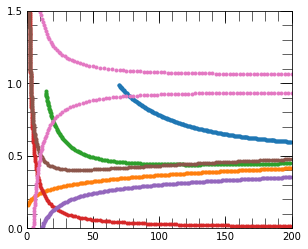

In [34]:
# load svg data only if we haven't already got it
try:
    doc_GGA1
except NameError:
    doc_GGA1 = Document('edelweiss_bands_GGA1.svg')
    doc_GGA1 = doc_GGA1.flatten_all_paths()

# these are the points for the GGA1 graph
graph_points_GGA1 = np.array([(0,0), (50,0), (100,0), (150,0), (200,0), (0,0.5), (0,1), (0,1.5)])

# get_calib_fn (doc, graph_points):
xcalib_fn, ycalib_fn = get_calib_fn(doc_GGA1, graph_points_GGA1)

curve_idx = [7, 13, 19, 21, 23, 46]
paths_GGA1 = []
for idx in curve_idx:
    paths_GGA1.append(get_paths(doc_GGA1, idx))
    
paths_GGA1 = list(itertools.chain(*paths_GGA1))
    
#print(paths_GGA1)

x_arr = np.linspace(0,1,200)
for path in paths_GGA1:
    path0_arr = get_points_from_path(path, x_arr, xcalib_fn, ycalib_fn)
    plt.plot(path0_arr[:,0], path0_arr[:,1],'.')
    
    
#path1_arr = get_points_from_path(paths_GGA1[1], x_arr, xcalib_fn, ycalib_fn)

#plt.plot(path0_arr[:,0], path0_arr[:,1],'r')
#plt.plot(path1_arr[:,0], path1_arr[:,1],'r--')
minorLocatorX = MultipleLocator(10)
minorLocatorY = MultipleLocator(0.1)
ax = plt.gca()
ax.xaxis.set_minor_locator(minorLocatorX)
ax.yaxis.set_minor_locator(minorLocatorY)
plt.ylim(min(graph_points_GGA1[:,1]),max(graph_points_GGA1[:,1]))
plt.yticks(list(set(graph_points_GGA1[:,1])))
plt.tick_params(which="major", right=True, top=True, direction="in", length=12)
plt.tick_params(which="minor", right=True, top=True, direction="in", length=10)
# see https://jdhao.github.io/2017/06/03/change-aspect-ratio-in-mpl/
ax.set_aspect(0.75*1.0/ax.get_data_ratio())
plt.xlim(0,200)
plt.xticks(list(set(graph_points_GGA1[:,0])))
plt.show()

In [6]:
doc_ER = Document('edelweiss_ER_band_GGA3.svg')
doc_ER = doc_ER.flatten_all_paths()

# these are the points for the ER graph
graph_points_ER = np.array([(0,0), (50,0), (100,0), (150,0), (200,0), (0,0.05), (0,0.1), (0,0.15)])

# get_calib_fn (doc, graph_points):
xcalib_fn_ER, ycalib_fn_ER = get_calib_fn(doc_ER, graph_points_ER)
    
print(xcalib_fn_ER(54.4), ycalib_fn_ER(64.4))
print(xcalib_fn_ER(68.8), ycalib_fn_ER(86))

34.73079000000004 175.06081 1.6618999999999744 147.37939999999998
[Line(start=(34.730800000000016+2.5768999999999664j), end=(175.06080000000006+2.5768999999999664j)), Line(start=(175.06080000000006+147.37939999999998j), end=(34.730800000000016+147.37939999999998j)), Line(start=(34.730800000000016+147.37939999999998j), end=(175.0608+147.37939999999998j))] [Line(start=(175.06080000000006+2.5768999999999664j), end=(175.06080000000006+147.37939999999998j)), Line(start=(34.730800000000016+147.37939999999998j), end=(34.730800000000016+2.5768999999999664j)), Line(start=(48.77955+147.37939999999998j), end=(48.77955+2.4343999999999824j)), Line(start=(62.8283+147.37939999999998j), end=(62.8283+2.41689999999997j)), Line(start=(76.8783+147.37939999999998j), end=(76.8783+1.6618999999999744j)), Line(start=(90.84705+147.37939999999998j), end=(90.84705+2.6393999999999664j)), Line(start=(104.89580000000001+147.37939999999998j), end=(104.89580000000001+2.509399999999971j)), Line(start=(118.9445499999999

In [7]:
doc_NR = Document('edelweiss_NR_band_GGA3.svg')
doc_NR = doc_NR.flatten_all_paths()

# these are the points for the NR graph
graph_points_NR = np.array([(0,0), (50,0), (100,0), (150,0), (0,0.025), (0,0.05), (0,0.075), (0, 0.1)])

# get_calib_fn (doc, graph_points):
xcalib_fn_NR, ycalib_fn_NR = get_calib_fn(doc_NR, graph_points_NR)

39.09999999999991 183.90000000000003 2.4593999999999028 147.37940000000003
[Line(start=(39.099999999999966+2.576909999999998j), end=(183.89999999999992+2.576909999999998j)), Line(start=(183.89999999999992+147.37940000000003j), end=(39.09999999999991+147.37940000000003j)), Line(start=(39.099999999999966+147.37939999999992j), end=(183.89999999999998+147.37939999999992j))] [Line(start=(183.89999999999992+2.576909999999998j), end=(183.89999999999992+147.37940000000003j)), Line(start=(39.09999999999991+147.37940000000003j), end=(39.09999999999991+2.576909999999998j)), Line(start=(48.67874999999998+147.37939999999992j), end=(48.67874999999998+2.509399999999914j)), Line(start=(58.33999999999998+147.37939999999992j), end=(58.33999999999998+2.4593999999999028j)), Line(start=(67.99624999999997+147.37939999999992j), end=(67.99624999999997+2.5268999999998982j)), Line(start=(77.65624999999997+147.37939999999992j), end=(77.65624999999997+2.6018999999999153j)), Line(start=(87.31374999999998+147.37939

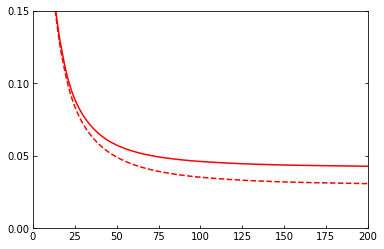

In [8]:
#paths[0].point(1)
# choose paths from ER with 13 lines (those are the curves)
paths_ER = get_paths(doc_ER, 13)

x_arr = np.linspace(0,1,100)
path0_arr = get_points_from_path(paths_ER[0], x_arr, xcalib_fn_ER, ycalib_fn_ER)
path1_arr = get_points_from_path(paths_ER[1], x_arr, xcalib_fn_ER, ycalib_fn_ER)
#print(path0_arr[1:5,:])
plt.plot(path0_arr[:,0], path0_arr[:,1],'r')
plt.plot(path1_arr[:,0], path1_arr[:,1],'r--')
plt.ylim(0,0.15)
plt.yticks([0, 0.05, 0.1, 0.15])
plt.tick_params(right=True, direction="in")
# see https://jdhao.github.io/2017/06/03/change-aspect-ratio-in-mpl/
#plt.Axes.set_aspect(1)
plt.xlim(0,200)
plt.show()

table = np.column_stack([path0_arr[:,0], path0_arr[:,1], path1_arr[:,0], path1_arr[:,1]])
#print(table)
headers=["'Erecoil (keV) for aH=0.035'", "'ER yield width for aH=0.035'", "'Erecoil (keV) for aH=0.02'", "'ER yield width for aH=0.02'"]
#print (tabulate(table, headers=headers, tablefmt="plain", numalign="left"))

#with open("edelweiss_ER_band_GGA3_curveData.txt", "w") as text_file:
#    print(tabulate(table, headers=headers, tablefmt="plain", numalign="left"), file=text_file)

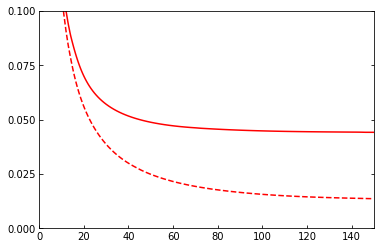

In [9]:
import itertools
# choose paths from NR with 13, 8 lines (those are the curves)
# this itertools thing is needed because get_paths returns an array of paths
#print(get_paths(doc_NR,8)[0])
paths_NR = list(itertools.chain(*(get_paths(doc_NR, 13), [get_paths(doc_NR,8)[0]])))
#print(paths_NR)
#print("end paths_NR")

x_arr = np.linspace(0,1,100)
path0_arr = get_points_from_path(paths_NR[0], x_arr, xcalib_fn_NR, ycalib_fn_NR)
path1_arr = get_points_from_path(paths_NR[1], x_arr, xcalib_fn_NR, ycalib_fn_NR)
#print(path0_arr[1:5,:])
plt.plot(path0_arr[:,0], path0_arr[:,1],'r--')
plt.plot(path1_arr[:,0], path1_arr[:,1],'r')
plt.ylim(0,0.1)
plt.xlim(0,150)
plt.yticks([0, 0.025, 0.05, 0.075, 0.1])
plt.tick_params(right=True, direction="in")
plt.show()


table = np.column_stack([path1_arr[:,0], path1_arr[:,1], path0_arr[:,0], path0_arr[:,1]])
#print(table)
headers=["'Erecoil (keV) for C=0.04'", "'ER yield width for C=0.04'", "'Erecoil (keV) for C=0'", "'ER yield width for C=0'"]
#print (tabulate(table, headers=headers, tablefmt="plain", numalign="left"))

#with open("edelweiss_NR_band_GGA3_curveData.txt", "w") as text_file:
#    print(tabulate(table, headers=headers, tablefmt="plain", numalign="left"), file=text_file)

In [10]:
idx = 5
print(paths[idx], attributes[idx])

print("path is continuous? ", paths[idx].iscontinuous())
print("path is closed? ", paths[idx].isclosed())

NameError: name 'paths' is not defined

In [ ]:
#paths[idx].isclosed()
